In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interactive, VBox, HBox, Output
from IPython.display import display

In [ ]:
def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong):
    """Vẽ một "đốm sáng" Gaussian 2D lên ma trận tại một vị trí."""
    k_thuoc = ma_tran.shape[0]
    y, x = vi_tri
    y = np.clip(y, 0, k_thuoc - 1)
    x = np.clip(x, 0, k_thuoc - 1)
    ys, xs = np.ogrid[:k_thuoc, :k_thuoc]
    khoang_cach_binh_phuong = (xs - x)**2 + (ys - y)**2
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / (2 * do_rong**2))
    ma_tran += dom_sang
    return ma_tran

def gia_lap_ban_do_tinh(goc_MCP, goc_PIP, goc_DIP, L1_scaled, L2_scaled, L3_scaled, k_thuoc=8):
    """
    Giả lập bản đồ TĨNH 8x8 - PHIÊN BẢN VẬT LÝ NÂNG CAO v5.0
    Logic Chiếu 2D Cải tiến: Mô phỏng sự "cuộn vào" khi gập.
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    y_base = 1.0
    x_base = 4.0
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP)

    # --- QUY LUẬT "LIÊN KẾT GÂN" ---
    stiffness = 0.0
    if goc_MCP > 70: stiffness += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness += (goc_PIP - 60) / 30.0
    stiffness = np.clip(stiffness, 0, 1.0)
    rad_DIP_thu_dong = rad_PIP * 0.5
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * (1 - stiffness)) + (rad_DIP_thu_dong * stiffness)
    # --- KẾT THÚC QUY LUẬT ---

    # --- 1. Tính toán tọa độ (LOGIC CHIẾU MỚI - "Cuộn vào") ---
    goc_tich_luy_MCP = rad_MCP
    y_MCP = y_base
    x_MCP = x_base
    goc_tich_luy_PIP = goc_tich_luy_MCP + rad_PIP
    y_PIP = y_base + L1_scaled * np.sin(goc_tich_luy_MCP)
    x_PIP = x_base - L1_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_MCP)))
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP_hieu_luc
    y_DIP = y_PIP + L2_scaled * np.sin(goc_tich_luy_PIP)
    x_DIP = x_PIP - L2_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_PIP)))
    y_Tip = y_DIP + L3_scaled * np.sin(goc_tich_luy_DIP)
    x_Tip = x_DIP - L3_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_DIP)))

    # --- 2. Vẽ 7 điểm ---
    vi_tri_MCP = (np.clip(y_MCP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_MCP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))
    vi_tri_PIP = (np.clip(y_PIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_PIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))
    vi_tri_DIP = (np.clip(y_DIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_DIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))
    vi_tri_Tip = (np.clip(y_Tip + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_Tip + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))

    tao_dom_gaussian(ban_do, vi_tri_MCP, cuong_do=0.6 * np.cos(rad_MCP), do_rong=1.5)
    tao_dom_gaussian(ban_do, vi_tri_PIP, cuong_do=0.8 * np.cos(rad_PIP), do_rong=1.2)
    tao_dom_gaussian(ban_do, vi_tri_DIP, cuong_do=0.7 * np.cos(rad_DIP_hieu_luc), do_rong=1.0)
    tao_dom_gaussian(ban_do, vi_tri_Tip, cuong_do=1.0, do_rong=1.0)
    y_Pad1 = (y_MCP + y_PIP) / 2.0; x_Pad1 = (x_MCP + x_PIP) / 2.0
    cuong_do_Pad1 = 1.0 * (rad_MCP / (np.pi/2)) + 0.1
    tao_dom_gaussian(ban_do, (np.clip(y_Pad1, 0, k_thuoc-1), np.clip(x_Pad1, 0, k_thuoc-1)), cuong_do_Pad1, do_rong=1.8)
    y_Pad2 = (y_PIP + y_DIP) / 2.0; x_Pad2 = (x_PIP + x_DIP) / 2.0
    cuong_do_Pad2 = 1.0 * (rad_PIP / (np.pi/2)) + 0.1
    tao_dom_gaussian(ban_do, (np.clip(y_Pad2, 0, k_thuoc-1), np.clip(x_Pad2, 0, k_thuoc-1)), cuong_do_Pad2, do_rong=1.5)
    y_Pad3 = (y_DIP + y_Tip) / 2.0; x_Pad3 = (x_DIP + x_Tip) / 2.0
    cuong_do_Pad3 = 1.0 * (rad_DIP_hieu_luc / (np.pi/2)) + 0.1
    tao_dom_gaussian(ban_do, (np.clip(y_Pad3, 0, k_thuoc-1), np.clip(x_Pad3, 0, k_thuoc-1)), cuong_do_Pad3, do_rong=1.2)

    # --- 4. Thêm nhiễu và Chuẩn hóa ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=8):
    """Giả lập bản đồ áp suất ĐỘNG (phản lực) khi thăm dò."""
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    do_rong = 2.0 - (do_cung / 10.0) * 1.5
    tao_dom_gaussian(ban_do, vi_tri_tham_do, cuong_do, do_rong)
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

def ve_khung_xuong_3d(ax, goc_MCP, goc_PIP, goc_DIP, mau='b', label=''):
    """
    Vẽ một mô hình khung xương 3D đơn giản của ngón tay.
    """
    L1 = 3 # Đốt gần (MCP -> PIP)
    L2 = 2 # Đốt giữa (PIP -> DIP)
    L3 = 1 # Đốt xa (DIP -> Đầu ngón)
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP = np.deg2rad(goc_DIP)

    J0 = [0, 0, 0]
    
    J1_y = L1 * np.cos(rad_MCP)
    J1_z = L1 * np.sin(rad_MCP)
    J1 = [0, J1_y, J1_z]
    
    goc_tich_luy_PIP = rad_MCP + rad_PIP
    J2_y = J1[1] + L2 * np.cos(goc_tich_luy_PIP)
    J2_z = J1[2] + L2 * np.sin(goc_tich_luy_PIP)
    J2 = [0, J2_y, J2_z]
    
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP
    Tip_y = J2[1] + L3 * np.cos(goc_tich_luy_DIP)
    Tip_z = J2[2] + L3 * np.sin(goc_tich_luy_DIP)
    Tip = [0, Tip_y, Tip_z]
    
    points = np.array([J0, J1, J2, Tip])
    
    ax.plot(points[:, 0], points[:, 1], points[:, 2], marker='o', color=mau, label=label)
    ax.set_xlabel('X')
    ax.set_ylabel('Y (Dọc ngón tay)')
    ax.set_zlabel('Z (Gập)')
    ax.set_title("Mô phỏng Mô hình Hóa Ngón tay 3D")
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 6])
    ax.set_zlim([0, 6])

# --- HÀM CẬP NHẬT GIAO DIỆN CHÍNH (ĐÃ NÂNG CẤP) ---

def cap_nhat_giao_dien(goc_MCP, goc_PIP, goc_DIP, do_cung):
    """
    Hàm này được gọi mỗi khi bạn kéo BẤT KỲ thanh trượt nào.
    Nó sẽ vẽ lại cả BA biểu đồ.
    """
    # 1. Tạo một khung hình mới với 3 ô (1 hàng, 3 cột)
    fig, (ax1, ax2, ax3_placeholder) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Vẽ Ô 1: Bản đồ Áp suất Tĩnh (Chỉ phụ thuộc 3 góc) ---
    ban_do_tinh = gia_lap_ban_do_tinh(goc_MCP, goc_PIP, goc_DIP, 
                                 L1_scaled=2.0, L2_scaled=2.0, L3_scaled=1.0)
    ax1.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1)
    ax1.set_title(f"Bản đồ Tĩnh (Hình dạng)")
    ax1.set_xticks(np.arange(8))
    ax1.set_yticks(np.arange(8))

    # --- Vẽ Ô 2: Bản đồ Áp suất Động (Chỉ phụ thuộc Độ cứng) ---
    # Giả sử chúng ta luôn "thăm dò" tại trung tâm (4, 4)
    vi_tri_tham_do = (4, 4)
    ban_do_dong = gia_lap_ban_do_dong(vi_tri_tham_do, do_cung)
    ax2.imshow(ban_do_dong, cmap='inferno', vmin=0, vmax=1)
    ax2.set_title(f"Bản đồ Động (Phản lực {do_cung:.1f}/10)")
    ax2.set_xticks(np.arange(8))
    ax2.set_yticks(np.arange(8))

    # --- Vẽ Ô 3: Mô hình 3D (Kết hợp) ---
    fig.delaxes(ax3_placeholder)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    
    # Vẽ ngón tay duỗi thẳng (để so sánh)
    ve_khung_xuong_3d(ax3, 0, 0, 0, mau='g', label='Duỗi thẳng (0°)')
    
    # Vẽ ngón tay co (theo 3 góc)
    # Gán nhãn (theo độ cứng)
    label_do_cung = f'Co cứng (Độ cứng {do_cung:.1f})'
    ve_khung_xuong_3d(ax3, goc_MCP, goc_PIP, goc_DIP, mau='r', label=label_do_cung)
    
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# --- TẠO CÁC THANH TRƯỢT (4 CÁI) ---

slider_MCP = widgets.IntSlider(value=30, min=0, max=90, step=1, description='Góc MCP:')
slider_PIP = widgets.IntSlider(value=50, min=0, max=90, step=1, description='Góc PIP:')
slider_DIP = widgets.IntSlider(value=10, min=0, max=90, step=1, description='Góc DIP:')

# Thêm thanh trượt mới cho Độ Cứng
slider_do_cung = widgets.FloatSlider(value=8.5, min=0.0, max=10.0, step=0.1, 
                                     description='Độ cứng:',
                                     readout_format='.1f')

# --- SẮP XẾP GIAO DIỆN VÀ HIỂN THỊ ---

# 1. Liên kết 4 thanh trượt với hàm cap_nhat_giao_dien
interactive_output = interactive(cap_nhat_giao_dien, 
                                 goc_MCP=slider_MCP, 
                                 goc_PIP=slider_PIP, 
                                 goc_DIP=slider_DIP,
                                 do_cung=slider_do_cung)

# 2. Tách riêng phần điều khiển (sliders) mà BẠN muốn
ui_controls = VBox([
    HBox([slider_MCP, slider_PIP]), 
    HBox([slider_DIP, slider_do_cung])
])

# 3. Tách riêng phần KẾT QUẢ (biểu đồ) từ hàm interactive
# (interactive_output.children[-1] chính là ô output)
output_charts = interactive_output.children[-1]

# 4. Hiển thị theo đúng thứ tự bạn muốn: Điều khiển ở trên, Kết quả ở dưới
display(VBox([ui_controls, output_charts]))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from tensorflow.keras.layers import BatchNormalization
print(f"Đã tải thư viện (TensorFlow version: {tf.__version__})")

Đã tải thư viện (TensorFlow version: 2.20.0)


In [17]:
# PHẦN 1: "NHÀ MÁY" GIẢ LẬP (ĐÃ NÂNG CẤP)
# =============================================================================

def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong):
    """Vẽ một "đốm sáng" Gaussian 2D lên ma trận tại một vị trí."""
    k_thuoc = ma_tran.shape[0]
    y, x = vi_tri
    y = np.clip(y, 0, k_thuoc - 1)
    x = np.clip(x, 0, k_thuoc - 1)
    ys, xs = np.ogrid[:k_thuoc, :k_thuoc]
    khoang_cach_binh_phuong = (xs - x)**2 + (ys - y)**2
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / (2 * do_rong**2))
    ma_tran += dom_sang
    return ma_tran

def gia_lap_ban_do_tinh(goc_MCP, goc_PIP, goc_DIP, L1_scaled, L2_scaled, L3_scaled, k_thuoc=8):
    """
    Giả lập bản đồ TĨNH 8x8 - PHIÊN BẢN VẬT LÝ NÂNG CAO v5.0
    Logic Chiếu 2D Cải tiến: Mô phỏng sự "cuộn vào" khi gập.
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    y_base = 1.0
    x_base = 4.0
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP)

    # --- QUY LUẬT "LIÊN KẾT GÂN" ---
    stiffness = 0.0
    if goc_MCP > 70: stiffness += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness += (goc_PIP - 60) / 30.0
    stiffness = np.clip(stiffness, 0, 1.0)
    rad_DIP_thu_dong = rad_PIP * 0.5
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * (1 - stiffness)) + (rad_DIP_thu_dong * stiffness)
    # --- KẾT THÚC QUY LUẬT ---

    # --- 1. Tính toán tọa độ (LOGIC CHIẾU MỚI - "Cuộn vào") ---
    goc_tich_luy_MCP = rad_MCP
    y_MCP = y_base
    x_MCP = x_base
    goc_tich_luy_PIP = goc_tich_luy_MCP + rad_PIP
    y_PIP = y_base + L1_scaled * np.sin(goc_tich_luy_MCP)
    x_PIP = x_base - L1_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_MCP)))
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP_hieu_luc
    y_DIP = y_PIP + L2_scaled * np.sin(goc_tich_luy_PIP)
    x_DIP = x_PIP - L2_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_PIP)))
    y_Tip = y_DIP + L3_scaled * np.sin(goc_tich_luy_DIP)
    x_Tip = x_DIP - L3_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_DIP)))

    # --- 2. Vẽ 7 điểm ---
    vi_tri_MCP = (np.clip(y_MCP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_MCP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))
    vi_tri_PIP = (np.clip(y_PIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_PIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))
    vi_tri_DIP = (np.clip(y_DIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_DIP + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))
    vi_tri_Tip = (np.clip(y_Tip + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1), np.clip(x_Tip + np.random.uniform(-0.1, 0.1), 0, k_thuoc-1))

    tao_dom_gaussian(ban_do, vi_tri_MCP, cuong_do=0.6 * np.cos(rad_MCP), do_rong=1.5)
    tao_dom_gaussian(ban_do, vi_tri_PIP, cuong_do=0.8 * np.cos(rad_PIP), do_rong=1.2)
    tao_dom_gaussian(ban_do, vi_tri_DIP, cuong_do=0.7 * np.cos(rad_DIP_hieu_luc), do_rong=1.0)
    tao_dom_gaussian(ban_do, vi_tri_Tip, cuong_do=1.0, do_rong=1.0)
    y_Pad1 = (y_MCP + y_PIP) / 2.0; x_Pad1 = (x_MCP + x_PIP) / 2.0
    cuong_do_Pad1 = 1.0 * (rad_MCP / (np.pi/2)) + 0.1
    tao_dom_gaussian(ban_do, (np.clip(y_Pad1, 0, k_thuoc-1), np.clip(x_Pad1, 0, k_thuoc-1)), cuong_do_Pad1, do_rong=1.8)
    y_Pad2 = (y_PIP + y_DIP) / 2.0; x_Pad2 = (x_PIP + x_DIP) / 2.0
    cuong_do_Pad2 = 1.0 * (rad_PIP / (np.pi/2)) + 0.1
    tao_dom_gaussian(ban_do, (np.clip(y_Pad2, 0, k_thuoc-1), np.clip(x_Pad2, 0, k_thuoc-1)), cuong_do_Pad2, do_rong=1.5)
    y_Pad3 = (y_DIP + y_Tip) / 2.0; x_Pad3 = (x_DIP + x_Tip) / 2.0
    cuong_do_Pad3 = 1.0 * (rad_DIP_hieu_luc / (np.pi/2)) + 0.1
    tao_dom_gaussian(ban_do, (np.clip(y_Pad3, 0, k_thuoc-1), np.clip(x_Pad3, 0, k_thuoc-1)), cuong_do_Pad3, do_rong=1.2)

    # --- 4. Thêm nhiễu và Chuẩn hóa ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=8):
    """Giả lập bản đồ áp suất ĐỘNG (phản lực) khi thăm dò."""
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    do_rong = 2.0 - (do_cung / 10.0) * 1.5
    tao_dom_gaussian(ban_do, vi_tri_tham_do, cuong_do, do_rong)
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

In [19]:
# PHẦN 2: TẠO DỮ LIỆU HUẤN LUYỆN (Dataset)
# =============================================================================

print("Đang tạo bộ dữ liệu huấn luyện (Dataset)...")
start_time = time.time()

SO_LUONG_MAU = 20000
K_THUOC = 8
VI_TRI_THAM_DO_MAC_DINH = (4, 4)

X_tinh = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
Y_tinh = np.zeros((SO_LUONG_MAU, 3))
X_dong = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
Y_dong = np.zeros((SO_LUONG_MAU, 1))

for i in range(SO_LUONG_MAU):
    # Tạo giá trị ngẫu nhiên
    goc_MCP_ngau_nhien = np.random.uniform(0, 90)
    goc_PIP_ngau_nhien = np.random.uniform(0, 90)
    goc_DIP_ngau_nhien = np.random.uniform(0, 90)
    do_cung_ngau_nhien = np.random.uniform(0, 10)
    L1_ngau_nhien = np.random.uniform(1.8, 2.2)
    L2_ngau_nhien = np.random.uniform(1.8, 2.2)
    L3_ngau_nhien = np.random.uniform(0.8, 1.2)

    # --- SỬA LỖI NGAY TẠI ĐÂY ---
    # Truyền đầy đủ các biến ngẫu nhiên vào hàm
    ban_do_tinh = gia_lap_ban_do_tinh(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien,
                                      L1_ngau_nhien, L2_ngau_nhien, L3_ngau_nhien, k_thuoc=K_THUOC)
    # -----------------------------

    X_tinh[i] = ban_do_tinh.reshape(K_THUOC, K_THUOC, 1)

    # Chuẩn hóa Y_tinh về 0-1 (Cho model sigmoid)
    Y_tinh[i] = [goc_MCP_ngau_nhien / 90.0,
                 goc_PIP_ngau_nhien / 90.0,
                 goc_DIP_ngau_nhien / 90.0]

    # Tạo dữ liệu cho Model 2 (Giữ nguyên)
    ban_do_dong = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH, do_cung_ngau_nhien, k_thuoc=K_THUOC)
    X_dong[i] = ban_do_dong.reshape(K_THUOC, K_THUOC, 1)
    Y_dong[i] = [do_cung_ngau_nhien]

print(f"Đã tạo {SO_LUONG_MAU} mẫu dữ liệu trong {time.time() - start_time:.2f} giây.")

print(f"Đã tạo {SO_LUONG_MAU} mẫu dữ liệu trong {time.time() - start_time:.2f} giây.")

Đang tạo bộ dữ liệu huấn luyện (Dataset)...
Đã tạo 20000 mẫu dữ liệu trong 9.26 giây.
Đã tạo 20000 mẫu dữ liệu trong 9.26 giây.


In [20]:
# PHẦN 3.1: XÂY DỰNG VÀ HUẤN LUYỆN MODEL 1 (ĐOÁN GÓC)
# =============================================================================

print("\n--- Bắt đầu Huấn luyện Model 1 (Đoán Góc) ---")

# ... (Code tạo model_1 giữ nguyên) ...
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(K_THUOC, K_THUOC, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), 
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3), 
    Dense(64, activation='relu'),
    
    # THAY ĐỔI Ở ĐÂY: Thêm activation='sigmoid'
    Dense(3, activation='sigmoid') # Output giờ sẽ luôn từ 0 đến 1
])
optimizer_moi = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_1.compile(optimizer=optimizer_moi, loss='mean_squared_error', metrics=['mae'])
model_1.summary()


--- Bắt đầu Huấn luyện Model 1 (Đoán Góc) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,163 (235.01 KB)

 Trainable params: 60,163 (235.01 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# PHẦN 3.2: XÂY DỰNG VÀ HUẤN LUYỆN MODEL 1 (ĐOÁN GÓC)
# =============================================================================
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # Tăng patience
checkpoint_1 = ModelCheckpoint('model_doan_goc_2.keras', save_best_only=True, monitor='val_loss')

print("Huấn luyện Model 1...")
history_1 = model_1.fit(
    X_tinh, Y_tinh,
    epochs=1000, # Tăng epochs
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_1]
)
print("Đã lưu Model 1 (tốt nhất) vào 'model_doan_goc_best.keras'.")

Huấn luyện Model 1...
Epoch 1/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0631 - mae: 0.2111 - val_loss: 0.0427 - val_mae: 0.1676
Epoch 2/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0395 - mae: 0.1565 - val_loss: 0.0341 - val_mae: 0.1399
Epoch 3/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0349 - mae: 0.1421 - val_loss: 0.0322 - val_mae: 0.1326
Epoch 4/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0333 - mae: 0.1365 - val_loss: 0.0315 - val_mae: 0.1295
Epoch 5/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0323 - mae: 0.1329 - val_loss: 0.0307 - val_mae: 0.1267
Epoch 6/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0315 - mae: 0.1307 - val_loss: 0.0300 - val_mae: 0.1245
Epoch 7/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0308 - mae: 0.1286 - val_loss: 0.0294 - val_mae: 0.1230
Epoch 8/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0301 - mae: 0.1266 - val_loss: 0.0286 - val_mae: 0.1204
Epoch 9/1000
250/2

Đang tải thư viện và mô hình đã huấn luyện...
Tải 'model_doan_goc_best.keras' thành công.
Đang tạo lại bộ dữ liệu (20.000 mẫu). Xin chờ...
Đã tạo lại dữ liệu trong 7.41 giây.
Đã tách ra 4000 mẫu kiểm tra.
Đang chạy dự đoán trên toàn bộ mẫu kiểm tra...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- PHÂN TÍCH 20 TRƯỜNG HỢP LỖI CAO NHẤT ---
(Tổng lỗi trung bình (val_mae) tính toán lại: 6.19 độ)

#1. Lỗi cao thứ 1 (Sai trung bình: 25.9 độ)
  > Sự thật: MCP=7.5, PIP=56.5, DIP=4.6
  > AI đoán:  MCP=9.7, PIP=37.6, DIP=61.2

#2. Lỗi cao thứ 2 (Sai trung bình: 22.2 độ)
  > Sự thật: MCP=4.6, PIP=88.4, DIP=81.2
  > AI đoán:  MCP=8.9, PIP=86.7, DIP=20.7

#3. Lỗi cao thứ 3 (Sai trung bình: 22.0 độ)
  > Sự thật: MCP=32.2, PIP=49.1, DIP=19.1
  > AI đoán:  MCP=38.9, PIP=25.1, DIP=54.1

#4. Lỗi cao thứ 4 (Sai trung bình: 21.7 độ)
  > Sự thật: MCP=65.6, PIP=89.7, DIP=2.4
  > AI đoán:  MCP=68.4, PIP=85.1, DIP=60.1

#5. Lỗi cao thứ 5 (Sai trung bình: 21.7 độ)
  > Sự thật: MCP=87.7, PIP=42.6, DIP=89.1
  > A

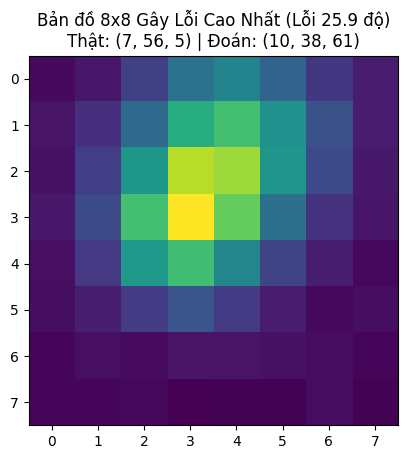

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

print("Đang tải thư viện và mô hình đã huấn luyện...")

# Tải mô hình AI đã huấn luyện (sigmoid output)
try:
    # Đảm bảo đây là tên file model đã train với sigmoid
    model = tf.keras.models.load_model('model_doan_goc_2.keras') 
    print("Tải 'model_doan_goc_2.keras' thành công.")
except IOError:
    print("LỖI: Không tìm thấy file model.")
    exit()

# =============================================================================
# PHẦN 1: TÁI TẠO BỘ DỮ LIỆU
# (SAO CHÉP Y HỆT HÀM gia_lap_ban_do_tinh TỪ FILE train_ai.py MÀ BẠN ĐÃ DÙNG ĐỂ TRAIN MODEL Ở TRÊN)
# =============================================================================

K_THUOC = 8
SO_LUONG_MAU = 20000 

# === SAO CHÉP Y HỆT CÁC HÀM GIẢ LẬP TỪ FILE TRAIN ===
def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong):
    # ... (code y hệt file train) ...
    k_thuoc = ma_tran.shape[0]; y, x = vi_tri
    y = np.clip(y, 0, k_thuoc - 1); x = np.clip(x, 0, k_thuoc - 1)
    ys, xs = np.ogrid[:k_thuoc, :k_thuoc]
    khoang_cach_binh_phuong = (xs - x)**2 + (ys - y)**2
    do_rong_squared = max(do_rong**2, 1e-6) 
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / (2 * do_rong_squared))
    ma_tran += dom_sang; return ma_tran

def gia_lap_ban_do_tinh(goc_MCP, goc_PIP, goc_DIP, L1_scaled, L2_scaled, L3_scaled, k_thuoc=8):
    # --- ĐẢM BẢO ĐÂY LÀ PHIÊN BẢN HÀM BẠN ĐÃ DÙNG ĐỂ TRAIN ---
    # (Ví dụ: phiên bản v5.0 với logic "cuộn vào")
    ban_do = np.zeros((k_thuoc, k_thuoc)); y_base = 1.0; x_base = 4.0
    rad_MCP = np.deg2rad(goc_MCP); rad_PIP = np.deg2rad(goc_PIP); rad_DIP_chu_dong = np.deg2rad(goc_DIP)
    stiffness = 0.0
    if goc_MCP > 70: stiffness += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness += (goc_PIP - 60) / 30.0
    stiffness = np.clip(stiffness, 0, 1.0); rad_DIP_thu_dong = rad_PIP * 0.5 
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * (1 - stiffness)) + (rad_DIP_thu_dong * stiffness)
    goc_tich_luy_MCP = rad_MCP; y_MCP = y_base; x_MCP = x_base
    goc_tich_luy_PIP = goc_tich_luy_MCP + rad_PIP
    y_PIP = y_base + L1_scaled * np.sin(goc_tich_luy_MCP) 
    x_PIP = x_base - L1_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_MCP))) 
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP_hieu_luc
    y_DIP = y_PIP + L2_scaled * np.sin(goc_tich_luy_PIP)
    x_DIP = x_PIP - L2_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_PIP))) 
    y_Tip = y_DIP + L3_scaled * np.sin(goc_tich_luy_DIP)
    x_Tip = x_DIP - L3_scaled * np.tanh(1.0 * (1-np.cos(goc_tich_luy_DIP)))
    vi_tri_MCP = (y_MCP + np.random.uniform(-0.1, 0.1), x_MCP + np.random.uniform(-0.1, 0.1))
    vi_tri_PIP = (y_PIP + np.random.uniform(-0.1, 0.1), x_PIP + np.random.uniform(-0.1, 0.1))
    vi_tri_DIP = (y_DIP + np.random.uniform(-0.1, 0.1), x_DIP + np.random.uniform(-0.1, 0.1))
    vi_tri_Tip = (y_Tip + np.random.uniform(-0.1, 0.1), x_Tip + np.random.uniform(-0.1, 0.1))
    cuong_do_MCP_val = max(0, 0.6 * np.cos(rad_MCP)); cuong_do_PIP_val = max(0, 0.8 * np.cos(rad_PIP)); cuong_do_DIP_val = max(0, 0.7 * np.cos(rad_DIP_hieu_luc))
    tao_dom_gaussian(ban_do, vi_tri_MCP, cuong_do=cuong_do_MCP_val, do_rong=1.5); tao_dom_gaussian(ban_do, vi_tri_PIP, cuong_do=cuong_do_PIP_val, do_rong=1.2); tao_dom_gaussian(ban_do, vi_tri_DIP, cuong_do=cuong_do_DIP_val, do_rong=1.0); tao_dom_gaussian(ban_do, vi_tri_Tip, cuong_do=1.0, do_rong=1.0)
    y_Pad1 = (y_MCP + y_PIP) / 2.0; x_Pad1 = (x_MCP + x_PIP) / 2.0; cuong_do_Pad1 = max(0.1, 1.0 * (rad_MCP / (np.pi/2)) + 0.1)
    tao_dom_gaussian(ban_do, (np.clip(y_Pad1, 0, k_thuoc-1), np.clip(x_Pad1, 0, k_thuoc-1)), cuong_do_Pad1, do_rong=1.8)
    y_Pad2 = (y_PIP + y_DIP) / 2.0; x_Pad2 = (x_PIP + x_DIP) / 2.0; cuong_do_Pad2 = max(0.1, 1.0 * (rad_PIP / (np.pi/2)) + 0.1)
    tao_dom_gaussian(ban_do, (np.clip(y_Pad2, 0, k_thuoc-1), np.clip(x_Pad2, 0, k_thuoc-1)), cuong_do_Pad2, do_rong=1.5)
    y_Pad3 = (y_DIP + y_Tip) / 2.0; x_Pad3 = (x_DIP + x_Tip) / 2.0; cuong_do_Pad3 = max(0.1, 1.0 * (rad_DIP_hieu_luc / (np.pi/2)) + 0.1)
    tao_dom_gaussian(ban_do, (np.clip(y_Pad3, 0, k_thuoc-1), np.clip(x_Pad3, 0, k_thuoc-1)), cuong_do_Pad3, do_rong=1.2)
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1; ban_do += nhieu
    if ban_do.max() > 0: ban_do = ban_do / ban_do.max()
    return ban_do
# ======================================================

print("Đang tạo lại bộ dữ liệu (20.000 mẫu). Xin chờ...")
start_time = time.time()

X_tinh = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1)) 
# Y_tinh_raw LƯU GIÁ TRỊ GỐC 0-90 ĐỘ
Y_tinh_raw = np.zeros((SO_LUONG_MAU, 3)) 
# Y_tinh_norm LƯU GIÁ TRỊ CHUẨN HÓA 0-1 (Để kiểm tra loss nếu cần)
Y_tinh_norm = np.zeros((SO_LUONG_MAU, 3)) 

for i in range(SO_LUONG_MAU):
    goc_MCP_ngau_nhien = np.random.uniform(0, 90)
    goc_PIP_ngau_nhien = np.random.uniform(0, 90)
    goc_DIP_ngau_nhien = np.random.uniform(0, 90)
    L1_ngau_nhien = np.random.uniform(1.8, 2.2) 
    L2_ngau_nhien = np.random.uniform(1.8, 2.2)
    L3_ngau_nhien = np.random.uniform(0.8, 1.2)
    
    ban_do_tinh = gia_lap_ban_do_tinh(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien,
                                      L1_ngau_nhien, L2_ngau_nhien, L3_ngau_nhien, k_thuoc=K_THUOC)
    X_tinh[i] = ban_do_tinh.reshape(K_THUOC, K_THUOC, 1)
    
    # Lưu cả 2 phiên bản của Y
    Y_tinh_raw[i] = [goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien]
    Y_tinh_norm[i] = [goc_MCP_ngau_nhien / 90.0, goc_PIP_ngau_nhien / 90.0, goc_DIP_ngau_nhien / 90.0]

print(f"Đã tạo lại dữ liệu trong {time.time() - start_time:.2f} giây.")

# =============================================================================
# PHẦN 2: TÁCH DỮ LIỆU VÀ PHÂN TÍCH LỖI
# =============================================================================

validation_split_ratio = 0.2
split_index = int(SO_LUONG_MAU * (1 - validation_split_ratio))

X_val = X_tinh[split_index:] 
# === THAY ĐỔI Ở ĐÂY: Dùng Y_tinh_raw (0-90 độ) để làm đáp án thật ===
Y_val_true = Y_tinh_raw[split_index:] 
# ==============================================================

print(f"Đã tách ra {len(X_val)} mẫu kiểm tra.")

print("Đang chạy dự đoán trên toàn bộ mẫu kiểm tra...")
# Y_pred_raw sẽ có giá trị từ 0-1 (do sigmoid)
Y_pred_raw = model.predict(X_val)

# Tỷ lệ lại kết quả dự đoán về 0-90 độ
Y_pred = Y_pred_raw * 90.0

# Tính toán lỗi (So sánh dự đoán 0-90 với đáp án thật 0-90)
errors = np.abs(Y_pred - Y_val_true) # Dùng Y_val_true
avg_errors_per_sample = np.mean(errors, axis=1)

sorted_indices = np.argsort(avg_errors_per_sample)[::-1] 

# =============================================================================
# PHẦN 3: IN KẾT QUẢ PHÂN TÍCH (Giữ nguyên, vì đã dùng Y_pred đúng)
# =============================================================================
# ... (Code in kết quả và vẽ đồ thị giữ nguyên) ...
print("\n--- PHÂN TÍCH 20 TRƯỜNG HỢP LỖI CAO NHẤT ---")
actual_val_mae = np.mean(avg_errors_per_sample) # Tính lại MAE thực tế
print(f"(Tổng lỗi trung bình (val_mae) tính toán lại: {actual_val_mae:.2f} độ)")

for i in range(min(20, len(sorted_indices))): # Đảm bảo không vượt quá số mẫu
    idx = sorted_indices[i]
    
    true_angles = Y_val_true[idx] # Dùng đáp án thật (0-90)
    pred_angles = Y_pred[idx]     # Dùng dự đoán đã tỷ lệ (0-90)
    sample_error = avg_errors_per_sample[idx]
    
    print(f"\n#{i+1}. Lỗi cao thứ {i+1} (Sai trung bình: {sample_error:.1f} độ)")
    print(f"  > Sự thật: MCP={true_angles[0]:.1f}, PIP={true_angles[1]:.1f}, DIP={true_angles[2]:.1f}")
    print(f"  > AI đoán:  MCP={pred_angles[0]:.1f}, PIP={pred_angles[1]:.1f}, DIP={pred_angles[2]:.1f}")

if len(sorted_indices) > 0:
    print("\n--- TRỰC QUAN HÓA TRƯỜNG HỢP TỆ NHẤT (Lỗi #1) ---")
    idx_worst = sorted_indices[0]
    true_angles_worst = Y_val_true[idx_worst] # Dùng đáp án thật (0-90)
    pred_angles_worst = Y_pred[idx_worst]     # Dùng dự đoán đã tỷ lệ (0-90)
    anh_te_nhat = X_val[idx_worst].reshape(K_THUOC, K_THUOC)
    plt.imshow(anh_te_nhat, cmap='viridis')
    plt.title(f"Bản đồ 8x8 Gây Lỗi Cao Nhất (Lỗi {avg_errors_per_sample[idx_worst]:.1f} độ)\n"
              f"Thật: ({true_angles_worst[0]:.0f}, {true_angles_worst[1]:.0f}, {true_angles_worst[2]:.0f}) | "
              f"Đoán: ({pred_angles_worst[0]:.0f}, {pred_angles_worst[1]:.0f}, {pred_angles_worst[2]:.0f})") 
    plt.show()
else:
    print("Không có dữ liệu kiểm tra để trực quan hóa.")

In [29]:
# PHẦN 4.1: XÂY DỰNG VÀ HUẤN LUYỆN MODEL 2 (ĐOÁN ĐỘ CỨNG)
# =============================================================================

print("\n--- Bắt đầu Huấn luyện Model 2 (Đoán Độ Cứng) - TỐI ƯU ---")

model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(K_THUOC, K_THUOC, 1), padding='same'),
    BatchNormalization(), # Thêm Batch Norm
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(), # Thêm Batch Norm
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'), # Tăng nhẹ Dense layer
    Dropout(0.2), # Thêm Dropout nếu cần (chống overfitting)
    Dense(64, activation='relu'), 
    Dense(1) # Output: 1 con số độ cứng (vẫn linear)
])

# GIẢM LEARNING RATE
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_2.compile(optimizer=optimizer_2, loss='mean_squared_error', metrics=['mae']) 
# Bạn có thể thử loss='huber' nếu muốn:
# model_2.compile(optimizer=optimizer_2, loss=tf.keras.losses.Huber(), metrics=['mae'])

model_2.summary()


--- Bắt đầu Huấn luyện Model 2 (Đoán Độ Cứng) - TỐI ƯU ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,417 (236.00 KB)

 Trainable params: 60,225 (235.25 KB)

 Non-trainable params: 192 (768.00 B)

In [30]:
# PHẦN 4.2: XÂY DỰNG VÀ HUẤN LUYỆN MODEL 2 (ĐOÁN ĐỘ CỨNG)
# =============================================================================
checkpoint_2 = ModelCheckpoint(
    'model_doan_do_cung_best.keras', # Lưu file tốt nhất
    save_best_only=True,
    monitor='val_loss',
    verbose=1 # Thêm verbose để biết khi nào model được lưu
)

print("Huấn luyện Model 2 (Tối ưu)...")
history_2 = model_2.fit(
    X_dong, Y_dong, 
    epochs=1000, # Tăng epochs để có thời gian học với LR thấp
    batch_size=64, 
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_2] # Sử dụng callbacks
)
print("Đã lưu Model 2 (tốt nhất) vào 'model_doan_do_cung_best.keras'.")

Huấn luyện Model 2 (Tối ưu)...
Epoch 1/1000
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9635 - mae: 1.8095
Epoch 1: val_loss improved from None to 32.32884, saving model to model_doan_do_cung_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.6138 - mae: 0.9956 - val_loss: 32.3288 - val_mae: 4.9575
Epoch 2/1000
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6002 - mae: 0.5851
Epoch 2: val_loss improved from 32.32884 to 11.59832, saving model to model_doan_do_cung_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5348 - mae: 0.5523 - val_loss: 11.5983 - val_mae: 2.9639
Epoch 3/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4117 - mae: 0.4910
Epoch 3: val_loss improved from 11.59832 to 0.93589, saving model to model_doan_do_cung_best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3866 - mae: 0.4760 - val_loss: 0.9359 - val_mae: 0.8286
Epoch 4/1000
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3441 - mae: 0.4424
Epoch 4: val_loss i

In [45]:
# =============================================================================
# PHẦN 5: KIỂM TRA (TEST) MÔ HÌNH VỚI DỮ LIỆU NGẪU NHIÊN (CHI TIẾT LỖI GÓC)
# =============================================================================

print("\n--- Bắt đầu Kiểm tra AI (tải model TỐT NHẤT) ---")

try:
    best_model_1 = tf.keras.models.load_model('model_doan_goc_2.keras')
    best_model_2 = tf.keras.models.load_model('model_doan_do_cung_best.keras')
    print("Tải model thành công.")
except IOError:
    print("Lỗi: Không tìm thấy file model đã lưu.")
    exit()

# --- Số lượng ca test ngẫu nhiên ---
SO_CA_TEST = 5

print(f"\n--- KẾT QUẢ KIỂM TRA VỚI {SO_CA_TEST} TRƯỜNG HỢP NGẪU NHIÊN ---")

# Biến để lưu tổng lỗi cho từng khớp
total_error_mcp = 0
total_error_pip = 0
total_error_dip = 0
total_error_stiff = 0

for i in range(SO_CA_TEST):
    print(f"\n>> Trường hợp Ngẫu nhiên #{i+1}:")

    # 1. Tạo giá trị thật ngẫu nhiên
    goc_MCP_that = np.random.uniform(0, 90)
    goc_PIP_that = np.random.uniform(0, 90)
    goc_DIP_that = np.random.uniform(0, 90)
    do_cung_that = np.random.uniform(0, 10)
    L1_test = np.random.uniform(1.8, 2.2)
    L2_test = np.random.uniform(1.8, 2.2)
    L3_test = np.random.uniform(0.8, 1.2)

    # 2. Tạo "ảnh" giả lập từ giá trị thật
    anh_tinh_test = gia_lap_ban_do_tinh(goc_MCP_that, goc_PIP_that, goc_DIP_that, L1_test, L2_test, L3_test)
    VI_TRI_THAM_DO_MAC_DINH = (4, 4) # Giả sử luôn thăm dò tại trung tâm
    anh_dong_test = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH, do_cung_that)

    anh_tinh_test_input = anh_tinh_test.reshape(1, K_THUOC, K_THUOC, 1)
    anh_dong_test_input = anh_dong_test.reshape(1, K_THUOC, K_THUOC, 1)

    # 3. Yêu cầu AI dự đoán
    goc_du_doan_raw = best_model_1.predict(anh_tinh_test_input)
    goc_du_doan = goc_du_doan_raw * 90.0
    do_cung_du_doan = best_model_2.predict(anh_dong_test_input)

    # 4. In kết quả so sánh
    print(f"   Sự thật:   MCP={goc_MCP_that:.1f}, PIP={goc_PIP_that:.1f}, DIP={goc_DIP_that:.1f} | Độ cứng = {do_cung_that:.1f}")
    pred_mcp = goc_du_doan[0][0]
    pred_pip = goc_du_doan[0][1]
    pred_dip = goc_du_doan[0][2]
    pred_stiff = do_cung_du_doan[0][0]
    print(f"   AI đoán:  MCP={pred_mcp:.1f}, PIP={pred_pip:.1f}, DIP={pred_dip:.1f} | Độ cứng = {pred_stiff:.1f}")

    # 5. Tính và in lỗi CHI TIẾT cho từng khớp
    error_mcp = abs(pred_mcp - goc_MCP_that)
    error_pip = abs(pred_pip - goc_PIP_that)
    error_dip = abs(pred_dip - goc_DIP_that)
    error_stiff = abs(pred_stiff - do_cung_that)
    print(f"   => Lỗi: MCP: {error_mcp:.1f}°, PIP: {error_pip:.1f}°, DIP: {error_dip:.1f}° | Độ cứng: {error_stiff:.1f}")

    # Cộng dồn lỗi để tính trung bình cuối cùng
    total_error_mcp += error_mcp
    total_error_pip += error_pip
    total_error_dip += error_dip
    total_error_stiff += error_stiff

# In lỗi trung bình cho từng khớp sau khi chạy hết các ca test
avg_mae_mcp = total_error_mcp / SO_CA_TEST
avg_mae_pip = total_error_pip / SO_CA_TEST
avg_mae_dip = total_error_dip / SO_CA_TEST
avg_mae_stiff = total_error_stiff / SO_CA_TEST

print("\n--- LỖI TRUNG BÌNH (MAE) TRÊN CÁC CA TEST NGẪU NHIÊN ---")
print(f"   MAE MCP: {avg_mae_mcp:.2f} độ")
print(f"   MAE PIP: {avg_mae_pip:.2f} độ")
print(f"   MAE DIP: {avg_mae_dip:.2f} độ")
print(f"   MAE Độ cứng: {avg_mae_stiff:.2f}")

print("\nHoàn tất kiểm tra.")


--- Bắt đầu Kiểm tra AI (tải model TỐT NHẤT) ---
Tải model thành công.

--- KẾT QUẢ KIỂM TRA VỚI 5 TRƯỜNG HỢP NGẪU NHIÊN ---

>> Trường hợp Ngẫu nhiên #1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
   Sự thật:   MCP=11.6, PIP=66.7, DIP=85.8 | Độ cứng = 5.2
   AI đoán:  MCP=9.3, PIP=70.0, DIP=73.8 | Độ cứng = 5.3
   => Lỗi: MCP: 2.2°, PIP: 3.3°, DIP: 12.0° | Độ cứng: 0.0

>> Trường hợp Ngẫu nhiên #2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
   Sự thật:   MCP=36.5, PIP=20.2, DIP=56.3 | Độ cứng = 8.4
   AI đoán:  MCP=33.5, PIP=26.0, DIP=49.1 | Độ cứng = 8.2
   => Lỗi: MCP: 3.0°, PIP: 5.7°, DIP: 7.2° | Độ cứng: 0.2

>> Trường hợp Ngẫu nhiên #3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
   Sự thật:   MCP=1.5, PIP=55.4, DIP=12.3 | Độ cứng = 2.1
   AI đoán:  MCP=6.2, PIP=55.0, DIP=15.6 | Độ cứng = 1.7
   => Lỗi: MCP: 4.6°, PIP: 0.4°, DIP: 3.3° | Độ cứng: 0.4

>> Trường hợp Ngẫu nhiên #4:
1

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interactive, VBox, HBox, Output
from IPython.display import display

# =============================================================================
# PHẦN 1: CÁC HÀM GIẢ LẬP CỐT LÕI (v5.0)
# =============================================================================

# --- THAY THẾ HÀM CŨ BẰNG HÀM NÀY (v6.0) ---

def gia_lap_ban_do_tinh(goc_MCP, goc_PIP, goc_DIP, L1_scaled, L2_scaled, L3_scaled, k_thuoc=8):
    """
    Giả lập bản đồ TĨNH 8x8 - PHIÊN BẢN VẬT LÝ NÂNG CAO v6.0
    Logic Chiếu 2D "DẤU CHÂN" (Footprint) - Cảm biến nằm ngang.
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    
    x_base = 4.0 # Trục trung tâm của ngón tay
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP)

    # --- QUY LUẬT "LIÊN KẾT GÂN" (Giữ nguyên) ---
    stiffness = 0.0
    if goc_MCP > 70: stiffness += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness += (goc_PIP - 60) / 30.0
    stiffness = np.clip(stiffness, 0, 1.0)
    rad_DIP_thu_dong = rad_PIP * 0.5 
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * (1 - stiffness)) + (rad_DIP_thu_dong * stiffness)
    # --- KẾT THÚC QUY LUẬT ---
    
    # --- 1. Tính toán TỌA ĐỘ VÀ CƯỜNG ĐỘ của các điểm chạm ---
    
    # Logic: Khi gập, các đệm thịt (Pad) nhấc lên (cường độ giảm)
    # và các khớp (Joint) hạ xuống (cường độ tăng).
    
    # Vị trí Y (dọc ngón tay) của các điểm (giả định)
    y_Pad1 = 6.0 # Đệm thịt 1 (gần)
    y_MCP = 7.0 # Khớp MCP (sát gốc)
    
    y_Pad2 = 4.0 # Đệm thịt 2 (giữa)
    y_PIP = 5.0 # Khớp PIP
    
    y_Pad3 = 2.0 # Đệm thịt 3 (xa)
    y_DIP = 3.0 # Khớp DIP
    
    y_Tip = 1.0 # Đầu ngón tay
    
    # Vị trí X (ngang) - giữ ở giữa
    x_val = x_base + np.random.uniform(-0.1, 0.1)

    # --- 2. Tính Cường độ dựa trên Góc (Vật lý chính) ---
    
    # Cường độ Đệm thịt (Mạnh khi duỗi, yếu khi gập)
    cuong_do_Pad1 = 1.0 * np.cos(rad_MCP)
    cuong_do_Pad2 = 1.0 * np.cos(rad_PIP)
    cuong_do_Pad3 = 1.0 * np.cos(rad_DIP_hieu_luc)
    
    # Cường độ Khớp (Yếu khi duỗi, mạnh khi gập)
    cuong_do_MCP = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP = 1.0 * np.sin(rad_DIP_hieu_luc)
    
    # Đầu ngón tay (Tip) - Mạnh khi co vừa và gập cao
    cuong_do_Tip = 0.5 + 1.0 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. Vẽ 7 điểm (Với cường độ đã tính) ---
    tao_dom_gaussian(ban_do, (y_Pad1, x_val), cuong_do=cuong_do_Pad1, do_rong=1.5)
    tao_dom_gaussian(ban_do, (y_MCP, x_val), cuong_do=cuong_do_MCP, do_rong=1.2)
    
    tao_dom_gaussian(ban_do, (y_Pad2, x_val), cuong_do=cuong_do_Pad2, do_rong=1.5)
    tao_dom_gaussian(ban_do, (y_PIP, x_val), cuong_do=cuong_do_PIP, do_rong=1.2)
    
    tao_dom_gaussian(ban_do, (y_Pad3, x_val), cuong_do=cuong_do_Pad3, do_rong=1.5)
    tao_dom_gaussian(ban_do, (y_DIP, x_val), cuong_do=cuong_do_DIP, do_rong=1.2)
    
    tao_dom_gaussian(ban_do, (y_Tip, x_val), cuong_do=cuong_do_Tip, do_rong=1.0)
    
    # --- 4. Thêm nhiễu và Chuẩn hóa ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    return ban_do
def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=8):
    """Giả lập bản đồ áp suất ĐỘNG (phản lực) khi thăm dò."""
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    do_rong = 2.0 - (do_cung / 10.0) * 1.5
    tao_dom_gaussian(ban_do, vi_tri_tham_do, cuong_do, do_rong)
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

def ve_khung_xuong_3d(ax, goc_MCP, goc_PIP, goc_DIP, mau='b', label=''):
    """
    Vẽ một mô hình khung xương 3D đơn giản của ngón tay.
    """
    L1 = 3 # Đốt gần (MCP -> PIP)
    L2 = 2 # Đốt giữa (PIP -> DIP)
    L3 = 1 # Đốt xa (DIP -> Đầu ngón)
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP = np.deg2rad(goc_DIP)

    J0 = [0, 0, 0]
    
    J1_y = L1 * np.cos(rad_MCP)
    J1_z = L1 * np.sin(rad_MCP)
    J1 = [0, J1_y, J1_z]
    
    goc_tich_luy_PIP = rad_MCP + rad_PIP
    J2_y = J1[1] + L2 * np.cos(goc_tich_luy_PIP)
    J2_z = J1[2] + L2 * np.sin(goc_tich_luy_PIP)
    J2 = [0, J2_y, J2_z]
    
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP
    Tip_y = J2[1] + L3 * np.cos(goc_tich_luy_DIP)
    Tip_z = J2[2] + L3 * np.sin(goc_tich_luy_DIP)
    Tip = [0, Tip_y, Tip_z]
    
    points = np.array([J0, J1, J2, Tip])
    
    ax.plot(points[:, 0], points[:, 1], points[:, 2], marker='o', color=mau, label=label)
    ax.set_xlabel('X')
    ax.set_ylabel('Y (Dọc ngón tay)')
    ax.set_zlabel('Z (Gập)')
    ax.set_title("Mô phỏng Mô hình Hóa Ngón tay 3D")
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 6])
    ax.set_zlim([0, 6])

# =============================================================================
# PHẦN 2: TẠO GIAO DIỆN TƯƠNG TÁC (Widgets)
# =============================================================================

def cap_nhat_giao_dien(goc_MCP, goc_PIP, goc_DIP, do_cung):
    """
    Hàm này được gọi mỗi khi bạn kéo BẤT KỲ thanh trượt nào.
    Nó sẽ vẽ lại cả BA biểu đồ.
    """
    # 1. Tạo một khung hình mới với 3 ô (1 hàng, 3 cột)
    fig, (ax1, ax2, ax3_placeholder) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Vẽ Ô 1: Bản đồ Áp suất Tĩnh (Chỉ phụ thuộc 3 góc) ---
    # Sử dụng chiều dài đốt mặc định (trung bình của bộ train)
    ban_do_tinh = gia_lap_ban_do_tinh(goc_MCP, goc_PIP, goc_DIP, 
                                      L1_scaled=2.0, L2_scaled=2.0, L3_scaled=1.0)
    
    ax1.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1)
    ax1.set_title(f"Bản đồ Tĩnh (Hình dạng)")
    ax1.set_xticks(np.arange(8))
    ax1.set_yticks(np.arange(8))

    # --- Vẽ Ô 2: Bản đồ Áp suất Động (Chỉ phụ thuộc Độ cứng) ---
    # Giả sử chúng ta luôn "thăm dò" tại trung tâm (4, 4)
    vi_tri_tham_do = (4, 4)
    ban_do_dong = gia_lap_ban_do_dong(vi_tri_tham_do, do_cung)
    ax2.imshow(ban_do_dong, cmap='inferno', vmin=0, vmax=1)
    ax2.set_title(f"Bản đồ Động (Phản lực {do_cung:.1f}/10)")
    ax2.set_xticks(np.arange(8))
    ax2.set_yticks(np.arange(8))

    # --- Vẽ Ô 3: Mô hình 3D (Kết hợp) ---
    fig.delaxes(ax3_placeholder) # Xóa ô 2D tạm
    ax3 = fig.add_subplot(1, 3, 3, projection='3d') # Tạo ô 3D mới
    
    # Vẽ ngón tay duỗi thẳng (để so sánh)
    ve_khung_xuong_3d(ax3, 0, 0, 0, mau='g', label='Duỗi thẳng (0°)')
    
    # Vẽ ngón tay co (theo 3 góc)
    # Gán nhãn (theo độ cứng)
    label_do_cung = f'Co cứng (Độ cứng {do_cung:.1f})'
    ve_khung_xuong_3d(ax3, goc_MCP, goc_PIP, goc_DIP, mau='r', label=label_do_cung)
    
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# --- TẠO CÁC THANH TRƯỢT (4 CÁI) ---

slider_MCP = widgets.IntSlider(value=30, min=0, max=90, step=1, description='Góc MCP:')
slider_PIP = widgets.IntSlider(value=50, min=0, max=90, step=1, description='Góc PIP:')
slider_DIP = widgets.IntSlider(value=10, min=0, max=90, step=1, description='Góc DIP:')

# Thêm thanh trượt mới cho Độ Cứng
slider_do_cung = widgets.FloatSlider(value=8.5, min=0.0, max=10.0, step=0.1, 
                                     description='Độ cứng:',
                                     readout_format='.1f') # Hiển thị 1 chữ số thập phân

# --- SẮP XẾP GIAO DIỆN VÀ HIỂN THỊ ---

# 1. Liên kết 4 thanh trượt với hàm cap_nhat_giao_dien
interactive_output = interactive(cap_nhat_giao_dien, 
                                 goc_MCP=slider_MCP, 
                                 goc_PIP=slider_PIP, 
                                 goc_DIP=slider_DIP,
                                 do_cung=slider_do_cung) 

# 2. Tách riêng phần điều khiển (sliders)
ui_controls = VBox([
    HBox([slider_MCP, slider_PIP]), 
    HBox([slider_DIP, slider_do_cung])
])

# 3. Tách riêng phần KẾT QUẢ (biểu đồ)
output_charts = interactive_output.children[-1]

# 4. Hiển thị theo đúng thứ tự: Điều khiển ở trên, Kết quả ở dưới
display(VBox([ui_controls, output_charts]))

############################# 16x16 ###########################################

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interactive, VBox, HBox
from IPython.display import display

# =============================================================================
# PHẦN 1: CÁC HÀM GIẢ LẬP CỐT LÕI (v7.0 - 16x16)
# =============================================================================

def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận."""
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    # Tính toán cho hiệu ứng "quấn quanh" (wrap-around) trên trục X
    dx1 = xs - x
    dx2 = xs - (x + k_thuoc_x) 
    dx3 = xs - (x - k_thuoc_x) 
    dx = np.minimum(np.abs(dx1), np.minimum(np.abs(dx2), np.abs(dx3)))

    # Tránh chia cho 0
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=16): # Mặc định là 16
    """
    Giả lập bản đồ TĨNH 16x16 - PHIÊN BẢN v7.1 (ĐÃ TỐI ƯU)
    Logic "DẤU ẤN 360 ĐỘ" - Sửa lỗi "Liên kết Gân"
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) 

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) 
    influence_passive = stiffness_factor * 0.7 
    influence_active = 1.0 - influence_passive 
    rad_DIP_thu_dong = rad_PIP * 0.5 
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)
    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ (ĐÃ SCALE x2 CHO 16x16) ---
    scale = k_thuoc / 8.0 # Tỷ lệ = 16/8 = 2.0
    
    # Tọa độ Y (Dọc ngón tay)
    y_MCP_joint = 7.0 * scale
    y_Pad1 = 6.0 * scale
    y_PIP_joint = 5.0 * scale
    y_Pad2 = 4.0 * scale
    y_DIP_joint = 3.0 * scale
    y_Pad3 = 2.0 * scale
    y_Tip = 1.0 * scale
    
    # Tọa độ X (Chu vi ngón tay)
    x_back = 0.0 # Mu bàn tay (vẫn ở rìa)
    x_front = 4.0 * scale # Lòng bàn tay (ở giữa ma trận 16x16)

    # --- 2. TÍNH CƯỜNG ĐỘ (Giữ nguyên logic) ---
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc)
    
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT (ĐÃ SCALE x2) ---
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    return ban_do

# --- HÀM MỚI: tao_dom_gaussian_khong_wrap ---
def tao_dom_gaussian_khong_wrap(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận mà KHÔNG có hiệu ứng quấn quanh."""
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    dx = xs - x # Không "wrap-around"

    # Tránh chia cho 0
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- Cập nhật hàm gia_lap_ban_do_dong (ĐÃ SCALE x2) ---
def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=16): # Mặc định là 16
    """Giả lập bản đồ ĐỘNG 16x16 khi gantry thăm dò từ trên xuống."""
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    
    scale = k_thuoc / 8.0 # Tỷ lệ = 2.0
    
    # Scale độ rộng của đốm phản lực
    do_rong_y_dong = (0.8 - (do_cung / 10.0) * 0.4) * scale
    do_rong_x_dong = (0.8 - (do_cung / 10.0) * 0.4) * scale

    tao_dom_gaussian_khong_wrap(ban_do, vi_tri_tham_do, cuong_do, do_rong_y_dong, do_rong_x_dong)

    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

# --- HÀM ve_khung_xuong_3d (Không cần thay đổi) ---
def ve_khung_xuong_3d(ax, goc_MCP, goc_PIP, goc_DIP, mau='b', label=''):
    L1, L2, L3 = 3, 2, 1
    rad_MCP = np.deg2rad(goc_MCP); rad_PIP = np.deg2rad(goc_PIP); rad_DIP = np.deg2rad(goc_DIP)
    J0 = [0, 0, 0]
    J1 = [0, L1 * np.cos(rad_MCP), L1 * np.sin(rad_MCP)]
    goc_tich_luy_PIP = rad_MCP + rad_PIP
    J2 = [0, J1[1] + L2 * np.cos(goc_tich_luy_PIP), J1[2] + L2 * np.sin(goc_tich_luy_PIP)]
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP
    Tip = [0, J2[1] + L3 * np.cos(goc_tich_luy_DIP), J2[2] + L3 * np.sin(goc_tich_luy_DIP)]
    points = np.array([J0, J1, J2, Tip])
    ax.plot(points[:, 0], points[:, 1], points[:, 2], marker='o', color=mau, label=label)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title("Mô hình 3D"); ax.set_xlim([-1, 1]); ax.set_ylim([0, 6]); ax.set_zlim([0, 6])

# =============================================================================
# PHẦN 2: TẠO GIAO DIỆN TƯƠNG TÁC (ĐÃ CẬP NHẬT CHO 16x16)
# =============================================================================

def cap_nhat_giao_dien(goc_MCP, goc_PIP, goc_DIP, do_cung):
    fig, (ax1, ax2, ax3_placeholder) = plt.subplots(1, 3, figsize=(18, 6))
    
    K_THUOC_HIENTAI = 16 # Đặt kích thước ma trận là 16
    scale = K_THUOC_HIENTAI / 8.0 # = 2.0
    
    # --- Ô 1: BẢN ĐỒ TĨNH (16x16) ---
    ban_do_tinh = gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=K_THUOC_HIENTAI)
    im1 = ax1.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    ax1.set_title("Bản đồ Tĩnh 360° 16x16")
    ax1.set_xlabel(f"Chu vi (0: Mu, {4*scale:.0f}: Lòng)") # 0: Mu, 8: Lòng
    ax1.set_ylabel(f"Dọc ngón tay ({7*scale:.0f}: Gốc, 0: Ngọn)") # 14: Gốc
    ax1.set_xticks(np.arange(K_THUOC_HIENTAI))
    ax1.set_yticks(np.arange(K_THUOC_HIENTAI))
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # --- Ô 2: BẢN ĐỒ ĐỘNG (16x16) ---
    # Giả sử thăm dò khớp PIP (y=5*scale) ở mu bàn tay (x=0)
    vi_tri_tham_do = (5.0 * scale, 0) # (10, 0)
    ban_do_dong = gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=K_THUOC_HIENTAI)
    im2 = ax2.imshow(ban_do_dong, cmap='inferno', vmin=0, vmax=1, aspect='auto')
    ax2.set_title(f"Bản đồ Động (Phản lực {do_cung:.1f}/10)")
    ax2.set_xlabel("Chu vi ngón tay"); ax2.set_ylabel("Dọc ngón tay")
    ax2.set_xticks(np.arange(K_THUOC_HIENTAI))
    ax2.set_yticks(np.arange(K_THUOC_HIENTAI))
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # --- Ô 3: MÔ HÌNH 3D ---
    fig.delaxes(ax3_placeholder)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ve_khung_xuong_3d(ax3, 0, 0, 0, mau='g', label='Duỗi thẳng')
    ve_khung_xuong_3d(ax3, goc_MCP, goc_PIP, goc_DIP, mau='r', label=f'Co (Độ cứng {do_cung:.1f})')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# --- TẠO THANH TRƯỢT VÀ HIỂN THỊ ---
slider_MCP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc MCP:')
slider_PIP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc PIP:')
slider_DIP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc DIP:')
slider_do_cung = widgets.FloatSlider(value=5.0, min=0.0, max=10.0, step=0.1, 
                                     description='Độ cứng:', readout_format='.1f')

interactive_output = interactive(cap_nhat_giao_dien, goc_MCP=slider_MCP, goc_PIP=slider_PIP, 
                                 goc_DIP=slider_DIP, do_cung=slider_do_cung) 
ui_controls = VBox([HBox([slider_MCP, slider_PIP]), HBox([slider_DIP, slider_do_cung])])
output_charts = interactive_output.children[-1]
display(VBox([ui_controls, output_charts]))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from tensorflow.keras.layers import BatchNormalization
print(f"Đã tải thư viện (TensorFlow version: {tf.__version__})")

Đã tải thư viện (TensorFlow version: 2.20.0)


In [ ]:
# =============================================================================
# Ô CODE 2: CÁC HÀM GIẢ LẬP ĐỂ HUẤN LUYỆN (16x16)
# (Thay thế cho ô code 'd681bb57')
# =============================================================================

import numpy as np
import tensorflow as tf # Cần cho các hàm của train_ai.py

# --- HÀM GAUSSIAN CHO BẢN ĐỒ TĨNH (CÓ WRAP-AROUND) ---
def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    dx1 = xs - x; dx2 = xs - (x + k_thuoc_x); dx3 = xs - (x - k_thuoc_x) 
    dx = np.minimum(np.abs(dx1), np.minimum(np.abs(dx2), np.abs(dx3)))
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)
    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- HÀM GIẢ LẬP BẢN ĐỒ TĨNH v7.1 (ĐÃ SCALE 16x16) ---
def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=16): # Mặc định là 16
    ban_do = np.zeros((k_thuoc, k_thuoc))
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) 

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) 
    influence_passive = stiffness_factor * 0.7 
    influence_active = 1.0 - influence_passive 
    rad_DIP_thu_dong = rad_PIP * 0.5 
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)
    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ (ĐÃ SCALE) ---
    scale = k_thuoc / 8.0 # Tỷ lệ = 16/8 = 2.0
    y_MCP_joint = 7.0 * scale; y_Pad1 = 6.0 * scale
    y_PIP_joint = 5.0 * scale; y_Pad2 = 4.0 * scale
    y_DIP_joint = 3.0 * scale; y_Pad3 = 2.0 * scale
    y_Tip = 1.0 * scale
    x_back = 0.0 
    x_front = 4.0 * scale 

    # --- 2. TÍNH CƯỜNG ĐỘ (Giữ nguyên logic) ---
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT (ĐÃ SCALE) ---
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    return ban_do, goc_MCP, goc_PIP, np.rad2deg(rad_DIP_hieu_luc) # TRẢ VỀ CÁC GÓC HIỆU LỰC

# --- HÀM GAUSSIAN CHO BẢN ĐỒ ĐỘNG (KHÔNG WRAP) ---
def tao_dom_gaussian_khong_wrap(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    dx = xs - x 
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)
    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- HÀM GIẢ LẬP BẢN ĐỒ ĐỘNG (ĐÃ SCALE 16x16) ---
def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=16): # Mặc định là 16
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    scale = k_thuoc / 8.0 # = 2.0
    do_rong_y_dong = (0.8 - (do_cung / 10.0) * 0.4) * scale
    do_rong_x_dong = (0.8 - (do_cung / 10.0) * 0.4) * scale
    tao_dom_gaussian_khong_wrap(ban_do, vi_tri_tham_do, cuong_do, do_rong_y_dong, do_rong_x_dong)
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

In [ ]:
# =============================================================================
# Ô CODE 3: TẠO DỮ LIỆU HUẤN LUYỆN (16x16)
# (Thay thế cho ô code '55ef41a3')
# =============================================================================

print("Đang tạo bộ dữ liệu huấn luyện (Dataset)...")
start_time = time.time()

SO_LUONG_MAU = 50000
K_THUOC = 16 # <<< THAY ĐỔI CHÍNH
# Scale vị trí thăm dò cho 16x16
VI_TRI_THAM_DO_MAC_DINH_DONG = (5.0 * (K_THUOC / 8.0), 0) # (10, 0)

X_tinh = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
Y_tinh = np.zeros((SO_LUONG_MAU, 3)) # Sẽ chứa giá trị chuẩn hóa 0-1
X_dong = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
Y_dong = np.zeros((SO_LUONG_MAU, 1))

for i in range(SO_LUONG_MAU):
    # Tạo giá trị ngẫu nhiên
    goc_MCP_ngau_nhien = np.random.uniform(0, 90)
    goc_PIP_ngau_nhien = np.random.uniform(0, 90)
    goc_DIP_ngau_nhien = np.random.uniform(0, 90)
    do_cung_ngau_nhien = np.random.uniform(0, 10)
    
    # Gọi hàm giả lập v7.1 (nó sẽ tự động dùng k_thuoc=16)
    ban_do_tinh, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc = gia_lap_ban_do_tinh_v7(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)

    X_tinh[i] = ban_do_tinh.reshape(K_THUOC, K_THUOC, 1)

    # Chuẩn hóa Y_tinh về 0-1 (Dạy AI đoán góc hiệu lực)
    Y_tinh[i] = [goc_MCP_thuc / 90.0,
                 goc_PIP_thuc / 90.0,
                 goc_DIP_hieu_luc_thuc / 90.0] 
    
    # Tạo dữ liệu cho Model 2
    ban_do_dong = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH_DONG, do_cung_ngau_nhien, k_thuoc=K_THUOC)
    X_dong[i] = ban_do_dong.reshape(K_THUOC, K_THUOC, 1)
    Y_dong[i] = [do_cung_ngau_nhien]

print(f"Đã tạo {SO_LUONG_MAU} mẫu dữ liệu trong {time.time() - start_time:.2f} giây.")

Đang tạo bộ dữ liệu huấn luyện (Dataset)...


ValueError: too many values to unpack (expected 4)

In [7]:
# =============================================================================
# Ô CODE 4: XÂY DỰNG MODEL 1 (16x16)
# (Thay thế cho ô code '070dfb9e')
# =============================================================================

print("\n--- Bắt đầu Xây dựng Model 1 (Đoán Góc 16x16) ---")

model_1 = Sequential([
    # Input là ảnh 16x16x1
    Conv2D(32, (3, 3), activation='relu', input_shape=(K_THUOC, K_THUOC, 1), padding='same'),
    BatchNormalization(), # Thêm Batch Norm
    MaxPooling2D((2, 2)), # 16x16 -> 8x8
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 8x8 -> 4x4
    
    # Thêm một cặp Conv/Pool nữa vì input lớn hơn
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 4x4 -> 2x2
    
    Flatten(), # "Duỗi" ảnh 2x2x128
    
    Dense(128, activation='relu'),
    Dropout(0.4), # Tăng dropout một chút
    Dense(64, activation='relu'),
    
    Dense(3, activation='sigmoid') # Output 0-1
])

optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_1.compile(optimizer=optimizer_1, loss='mean_squared_error', metrics=['mae'])
model_1.summary()


--- Bắt đầu Xây dựng Model 1 (Đoán Góc 16x16) ---


d:\Simulation_ViSEF\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,683 (655.01 KB)

 Trainable params: 167,235 (653.26 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# =============================================================================
# Ô CODE 5: HUẤN LUYỆN MODEL 1 (16x16)
# (Thay thế cho ô code '086d9c74')
# =============================================================================

# Tăng patience cho EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1) 
# Đổi tên file checkpoint
checkpoint_1 = ModelCheckpoint('v1_16x16.keras', save_best_only=True, monitor='val_loss', verbose=1)

print("Huấn luyện Model 1 (16x16)...")
history_1 = model_1.fit(
    X_tinh, Y_tinh, 
    epochs=1000, # Đặt số epoch đủ cao
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_1]
)
print("Đã lưu Model 1 (tốt nhất) vào 'v1_16x16.keras'.")

Huấn luyện Model 1 (16x16)...
Epoch 1/1000
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - mae: 0.0451
Epoch 1: val_loss improved from None to 0.00241, saving model to v1_16x16.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0035 - mae: 0.0451 - val_loss: 0.0024 - val_mae: 0.0352
Epoch 2/1000
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - mae: 0.0443
Epoch 2: val_loss improved from 0.00241 to 0.00216, saving model to v1_16x16.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0034 - mae: 0.0441 - val_loss: 0.0022 - val_mae: 0.0340
Epoch 3/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - mae: 0.0433
Epoch 3: val_loss improved from 0.00216 to 0.00210, saving model to v1_16x16.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0032 - mae: 0.0431 - val_loss: 0.0021 - val_mae: 0.0351
Epoch 4/1000
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - mae: 0.0428
Epoch 4: val_loss did not improve from 0.00210
625/625 ━━━━━━

In [8]:
# =============================================================================
# Ô CODE MỚI: TẢI MODEL VÀ ĐÁNH GIÁ HIỆU SUẤT
# =============================================================================
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time # Để đo thời gian tạo dataset nếu chạy lại

# Đảm bảo các hàm giả lập đã được định nghĩa hoặc import
# Nếu bạn chạy từ đầu file Jupyter, chúng đã có sẵn.
# Nếu chạy riêng, cần import từ file giả lập:
# from your_simulation_file import gia_lap_ban_do_tinh_v7, gia_lap_ban_do_dong, tao_dom_gaussian, tao_dom_gaussian_khong_wrap

print("--- Bắt đầu kiểm tra hiệu suất mô hình ---")

# --- 1. Tải lại mô hình tốt nhất ---
# Đảm bảo tên file trùng với tên bạn đã dùng trong ModelCheckpoint
MODEL_PATH_1 = 'v1_16x16.keras' 
try:
    loaded_model_1 = tf.keras.models.load_model(MODEL_PATH_1)
    print(f"Đã tải thành công mô hình từ '{MODEL_PATH_1}'.")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Vui lòng đảm bảo rằng bạn đã chạy huấn luyện và mô hình đã được lưu.")
    loaded_model_1 = None

if loaded_model_1:
    # --- 2. Tạo lại dữ liệu (hoặc sử dụng X_tinh, Y_tinh đã có) ---
    # Nếu bạn chạy cell này độc lập, bạn sẽ cần tạo lại dataset
    # Nếu bạn chạy ngay sau cell huấn luyện, X_tinh và Y_tinh đã có sẵn
    if 'X_tinh' not in locals() or 'Y_tinh' not in locals() or X_tinh.shape[0] != SO_LUONG_MAU:
        print("\nĐang tạo lại bộ dữ liệu để đánh giá...")
        start_time_data = time.time()
        
        SO_LUONG_MAU = 50000 # Hoặc số lượng mẫu bạn đã dùng
        K_THUOC = 16 # Hoặc kích thước ma trận bạn đã dùng
        
        X_tinh_full = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
        Y_tinh_full = np.zeros((SO_LUONG_MAU, 3)) 

        for i in range(SO_LUONG_MAU):
            goc_MCP_ngau_nhien = np.random.uniform(0, 90)
            goc_PIP_ngau_nhien = np.random.uniform(0, 90)
            goc_DIP_ngau_nhien = np.random.uniform(0, 90)
            
            ban_do_tinh, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc = gia_lap_ban_do_tinh_v7(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)

            X_tinh_full[i] = ban_do_tinh.reshape(K_THUOC, K_THUOC, 1)
            Y_tinh_full[i] = [goc_MCP_thuc / 90.0,
                              goc_PIP_thuc / 90.0,
                              goc_DIP_hieu_luc_thuc / 90.0]
        
        # Chia lại thành tập train và validation để đảm bảo tính nhất quán
        _, X_val, _, Y_val = train_test_split(X_tinh_full, Y_tinh_full, test_size=0.2, random_state=42)
        print(f"Đã tạo lại và chia dữ liệu trong {time.time() - start_time_data:.2f} giây.")
    else:
        # Nếu X_tinh và Y_tinh đã có từ quá trình huấn luyện, chỉ cần lấy tập validation
        print("\nSử dụng dữ liệu đã có từ quá trình huấn luyện.")
        # Lấy tập validation từ lịch sử huấn luyện
        # Lưu ý: nếu bạn không tách tập test riêng, đây sẽ là tập validation
        # Nếu đã chia train_test_split thủ công, X_val, Y_val đã có.
        # Nếu không, cần phải chia lại một lần nữa
        _, X_val, _, Y_val = train_test_split(X_tinh, Y_tinh, test_size=0.2, random_state=42)
        
    # --- 3. Đánh giá mô hình trên tập validation ---
    print(f"\nĐánh giá Model 1 trên {len(X_val)} mẫu validation:")
    loss, mae = loaded_model_1.evaluate(X_val, Y_val, verbose=1)
    
    mae_degrees = mae * 90
    print(f"Loss trên tập validation: {loss:.4f}")
    print(f"MAE trên tập validation (chuẩn hóa): {mae:.4f}")
    print(f"MAE trên tập validation (độ): {mae_degrees:.2f} độ")
    
    print("\n--- Kết thúc kiểm tra hiệu suất cơ bản ---")
else:
    print("Không thể tiến hành đánh giá vì mô hình chưa được tải.")

--- Bắt đầu kiểm tra hiệu suất mô hình ---
Đã tải thành công mô hình từ 'v1_16x16.keras'.

Sử dụng dữ liệu đã có từ quá trình huấn luyện.

Đánh giá Model 1 trên 10000 mẫu validation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6712 - mae: 0.7613
Loss trên tập validation: 0.6712
MAE trên tập validation (chuẩn hóa): 0.7613
MAE trên tập validation (độ): 68.51 độ

--- Kết thúc kiểm tra hiệu suất cơ bản ---
